# COVID-19 Global Data Analysis

This notebook analyzes global COVID-19 trends, focusing on:
- Time trends of cases, deaths, and vaccinations
- Comparisons across countries and regions
- Population density correlation with infection rates
- Relationship between vaccination rates and mortality
- Impact of government responses on case numbers

## 1. Data Collection and Setup

First, we'll import necessary libraries and download the required datasets.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import os

# Set visualization style
sns.set_theme(style="whitegrid")

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

In [2]:
# Download the Our World in Data COVID-19 dataset
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
response = requests.get(url)

# Save the dataset locally
with open('data/owid-covid-data.csv', 'wb') as f:
    f.write(response.content)

print("COVID-19 data downloaded successfully.")

COVID-19 data downloaded successfully.


## 2. Data Loading and Exploration

Let's load the dataset and explore its structure.

In [3]:
# Load the COVID-19 dataset
covid_data = pd.read_csv('data/owid-covid-data.csv')

# Display basic information
print(f"Dataset shape: {covid_data.shape}")
covid_data.head()

Dataset shape: (429435, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [4]:
# Check column names and data types
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed                         409378 non-null  float64
 

## 3. Data Cleaning and Preparation

Let's clean the data and prepare it for analysis.

In [5]:
# Convert date column to datetime
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Define key columns for analysis
key_columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
               'total_vaccinations', 'people_vaccinated', 'population', 'population_density']

# Check for missing values in key columns
print("Missing values in key columns:")
covid_data[key_columns].isnull().sum()

Missing values in key columns:


total_cases            17631
new_cases              19276
total_deaths           17631
new_deaths             18827
total_vaccinations    344018
people_vaccinated     348303
population                 0
population_density     68943
dtype: int64

In [6]:
# Filter for countries of interest (top 10 most populated + specific healthcare systems)
top_populated = ['China', 'India', 'United States', 'Indonesia', 'Pakistan', 
                 'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico']
healthcare_systems = ['United Kingdom', 'Japan']
countries_of_interest = top_populated + healthcare_systems

# Filter the dataset
filtered_data = covid_data[covid_data['location'].isin(countries_of_interest)]

# Create regional groupings
regions = {
    'North America': ['United States', 'Mexico'],
    'South America': ['Brazil'],
    'Europe': ['United Kingdom', 'Russia'],
    'Asia': ['China', 'India', 'Indonesia', 'Pakistan', 'Bangladesh', 'Japan'],
    'Africa': ['Nigeria']
}

# Add region column
def assign_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return 'Other'

filtered_data['region'] = filtered_data['location'].apply(assign_region)

# Get the latest data for each country for later analysis
latest_data = filtered_data.sort_values('date').groupby('location').last().reset_index()

# Calculate cases per million for normalization
latest_data['cases_per_million'] = latest_data['total_cases'] / (latest_data['population'] / 1000000)
latest_data['deaths_per_million'] = latest_data['total_deaths'] / (latest_data['population'] / 1000000)
latest_data['mortality_rate'] = latest_data['total_deaths'] / latest_data['total_cases'] * 100

# Display country distribution
filtered_data['location'].value_counts()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12924\4059847023.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['region'] = filtered_data['location'].apply(assign_region)


location
India             1682
Mexico            1678
Brazil            1674
Bangladesh        1674
China             1674
Indonesia         1674
Japan             1674
Nigeria           1674
Pakistan          1674
Russia            1674
United Kingdom    1674
United States     1674
Name: count, dtype: int64

## 4. Time Trends Analysis

Let's analyze the time trends of cases, deaths, and vaccinations.

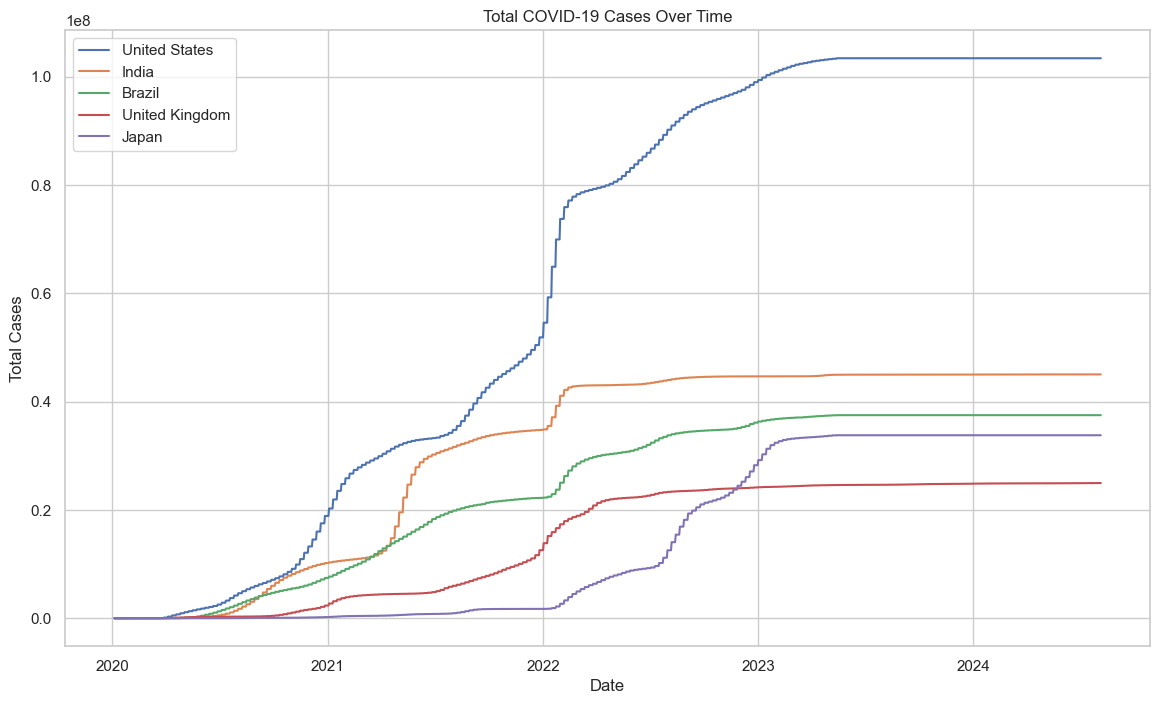

In [7]:
# Select a subset of countries for better visualization
selected_countries = ['United States', 'India', 'Brazil', 'United Kingdom', 'Japan']

# Plot total cases over time
plt.figure(figsize=(14, 8))
for country in selected_countries:
    country_data = filtered_data[filtered_data['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)
plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.show()

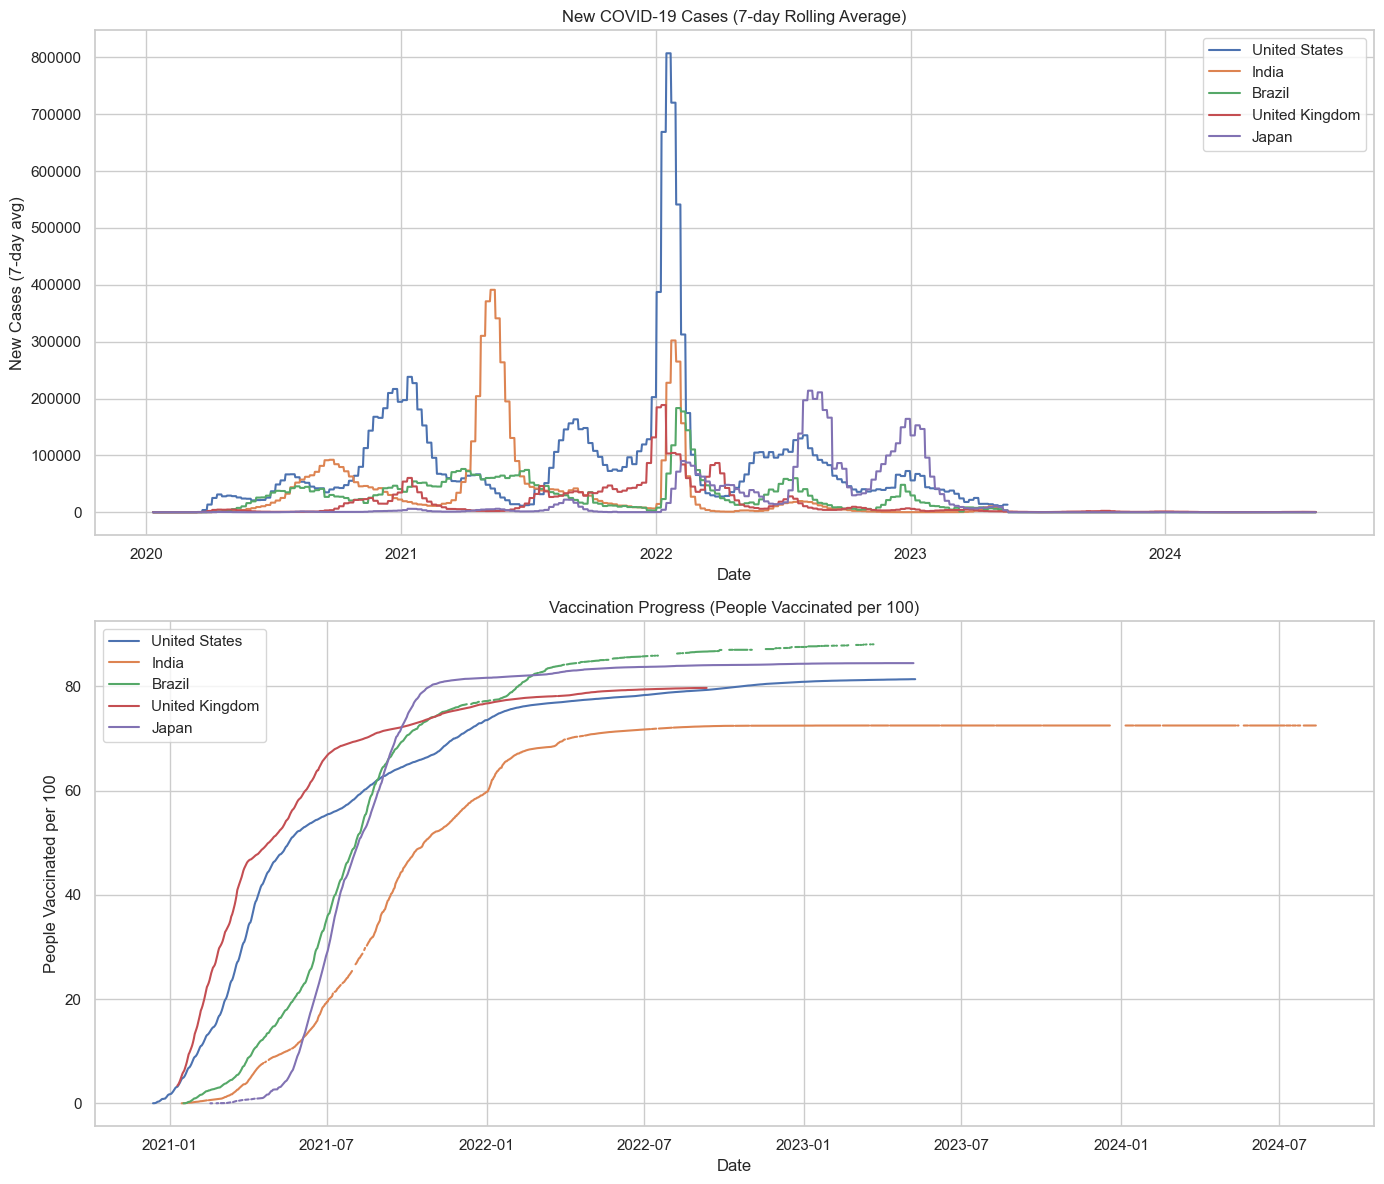

In [8]:
# Plot new cases (7-day rolling average) and vaccination progress
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# New cases plot
for country in selected_countries:
    country_data = filtered_data[filtered_data['location'] == country].copy()
    country_data['new_cases_smoothed'] = country_data['new_cases'].rolling(window=7).mean()
    ax1.plot(country_data['date'], country_data['new_cases_smoothed'], label=country)
ax1.set_title('New COVID-19 Cases (7-day Rolling Average)')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Cases (7-day avg)')
ax1.legend()
ax1.grid(True)

# Vaccination progress plot
for country in selected_countries:
    country_data = filtered_data[filtered_data['location'] == country]
    ax2.plot(country_data['date'], country_data['people_vaccinated_per_hundred'], label=country)
ax2.set_title('Vaccination Progress (People Vaccinated per 100)')
ax2.set_xlabel('Date')
ax2.set_ylabel('People Vaccinated per 100')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 5. Population Density and Infection Rate Analysis

Let's examine the relationship between population density and infection rates.

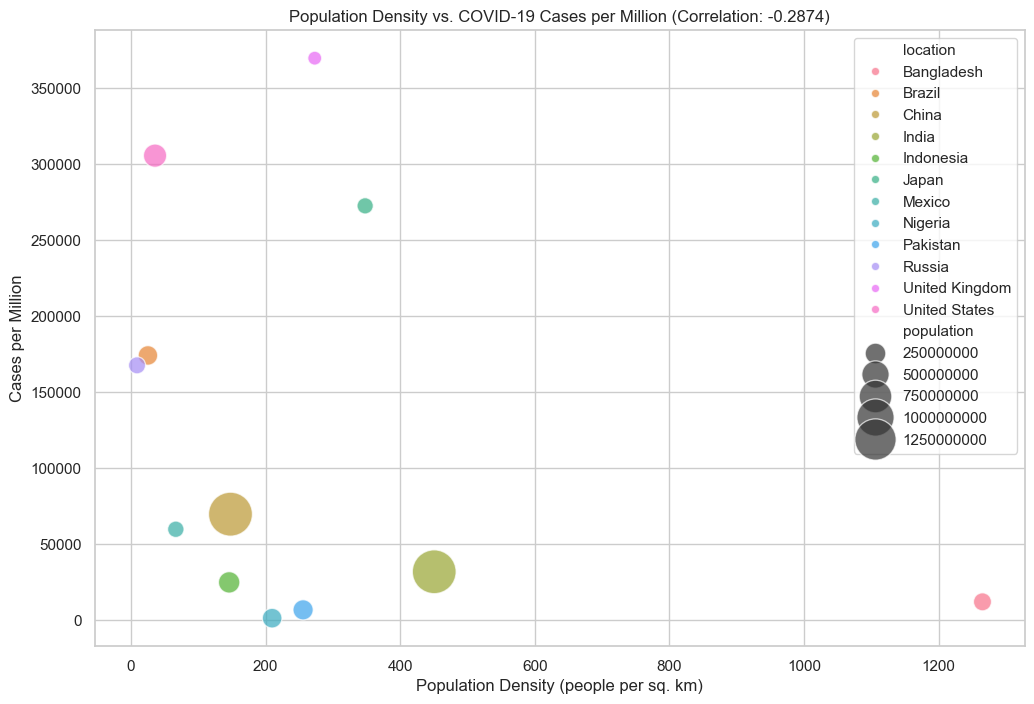

In [9]:
# Plot population density vs. cases per million
plt.figure(figsize=(12, 8))
sns.scatterplot(data=latest_data, x='population_density', y='cases_per_million', 
                hue='location', size='population', sizes=(100, 1000), alpha=0.7)

# Calculate correlation
correlation = latest_data['population_density'].corr(latest_data['cases_per_million'])
plt.title(f'Population Density vs. COVID-19 Cases per Million (Correlation: {correlation:.4f})')
plt.xlabel('Population Density (people per sq. km)')
plt.ylabel('Cases per Million')
plt.grid(True)
plt.show()

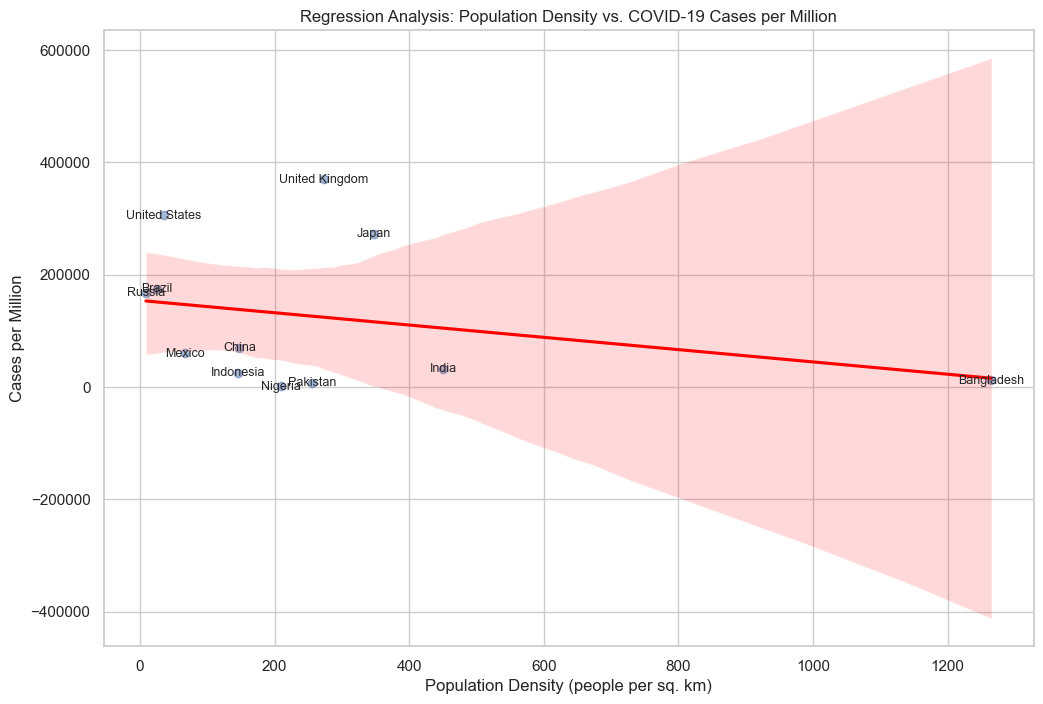

In [10]:
# Create a regression plot with country labels
plt.figure(figsize=(12, 8))
sns.regplot(data=latest_data, x='population_density', y='cases_per_million', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add country labels
for i, row in latest_data.iterrows():
    plt.text(row['population_density'], row['cases_per_million'], row['location'], 
             fontsize=9, ha='center', va='center')
    
plt.title('Regression Analysis: Population Density vs. COVID-19 Cases per Million')
plt.xlabel('Population Density (people per sq. km)')
plt.ylabel('Cases per Million')
plt.grid(True)
plt.show()

## 6. Vaccination Impact Analysis

Let's examine the relationship between vaccination rates and mortality trends.

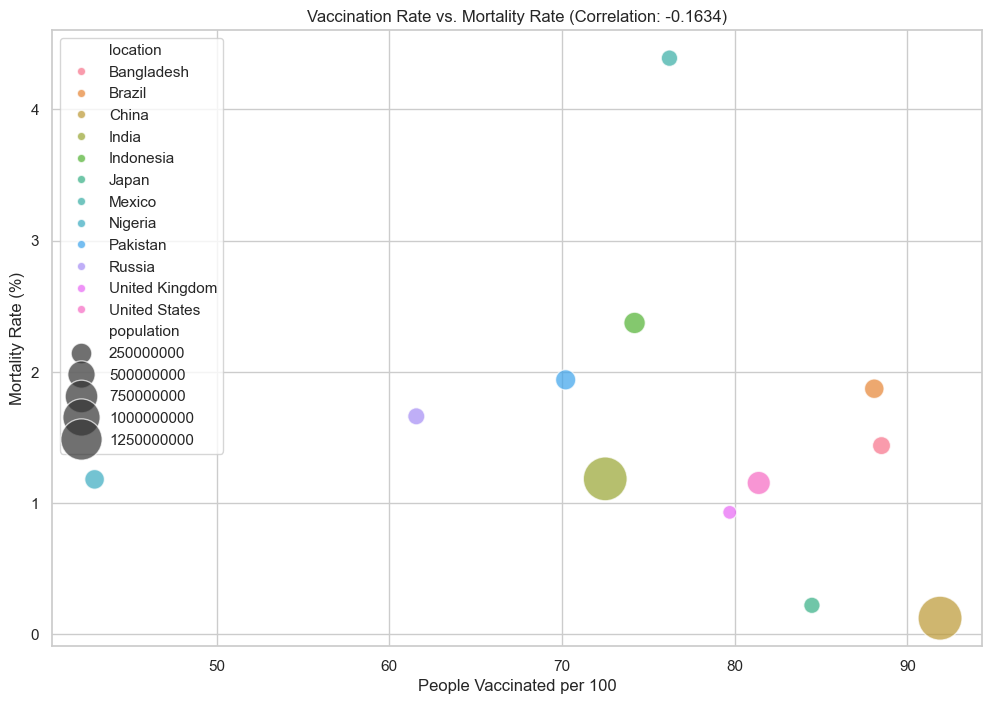

In [11]:
# Plot vaccination rate vs. mortality rate
plt.figure(figsize=(12, 8))
sns.scatterplot(data=latest_data, x='people_vaccinated_per_hundred', y='mortality_rate', 
                hue='location', size='population', sizes=(100, 1000), alpha=0.7)

# Calculate correlation
vax_mortality_corr = latest_data['people_vaccinated_per_hundred'].corr(latest_data['mortality_rate'])
plt.title(f'Vaccination Rate vs. Mortality Rate (Correlation: {vax_mortality_corr:.4f})')
plt.xlabel('People Vaccinated per 100')
plt.ylabel('Mortality Rate (%)')
plt.grid(True)
plt.show()

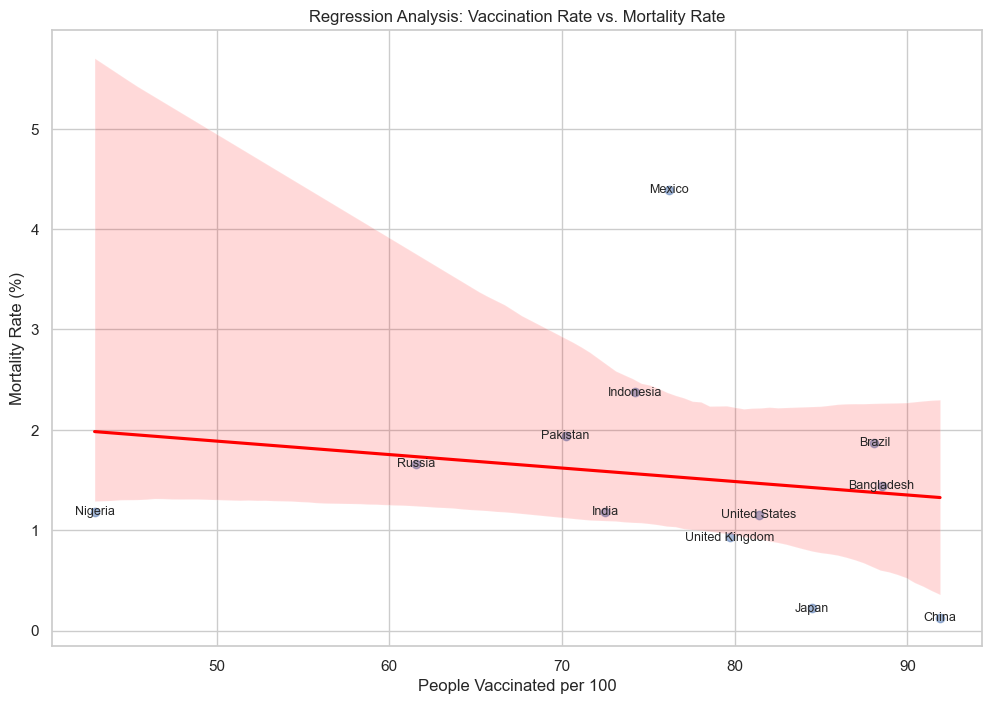

In [12]:
# Create a regression plot with country labels
plt.figure(figsize=(12, 8))
sns.regplot(data=latest_data, x='people_vaccinated_per_hundred', y='mortality_rate', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add country labels
for i, row in latest_data.iterrows():
    plt.text(row['people_vaccinated_per_hundred'], row['mortality_rate'], row['location'], 
             fontsize=9, ha='center', va='center')
    
plt.title('Regression Analysis: Vaccination Rate vs. Mortality Rate')
plt.xlabel('People Vaccinated per 100')
plt.ylabel('Mortality Rate (%)')
plt.grid(True)
plt.show()

## 7. Government Response Analysis

Let's analyze how different government responses affected case numbers.

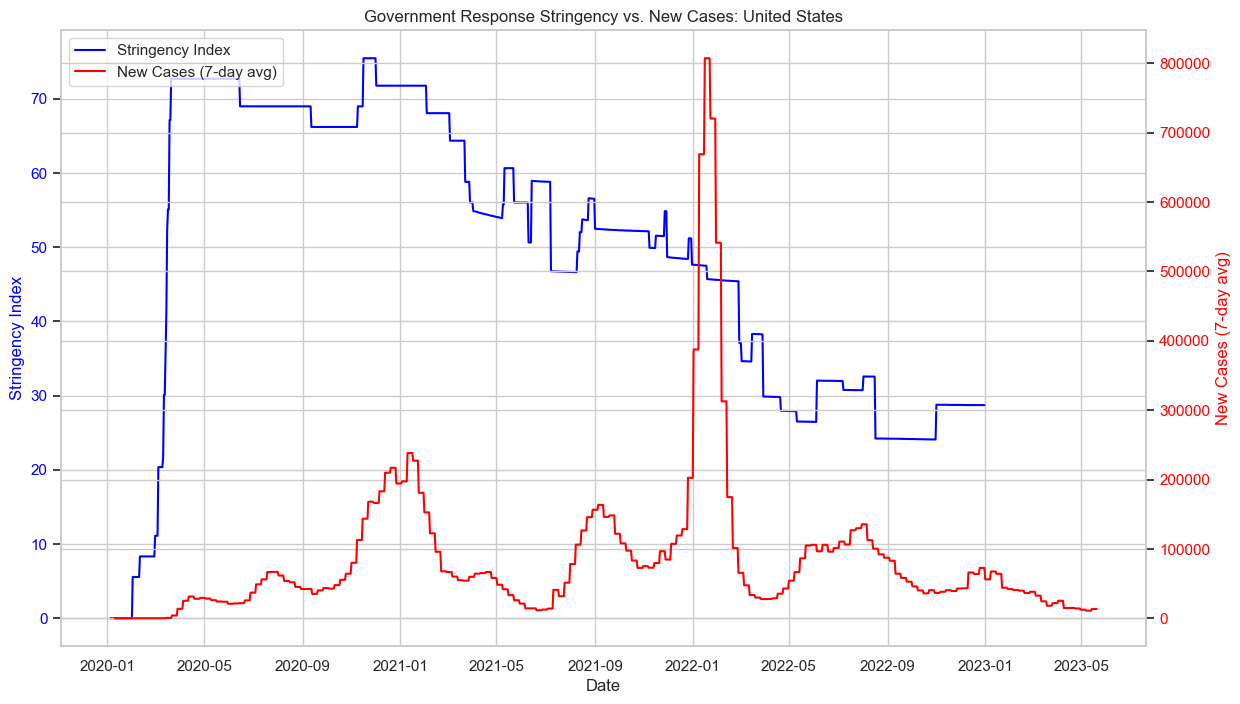

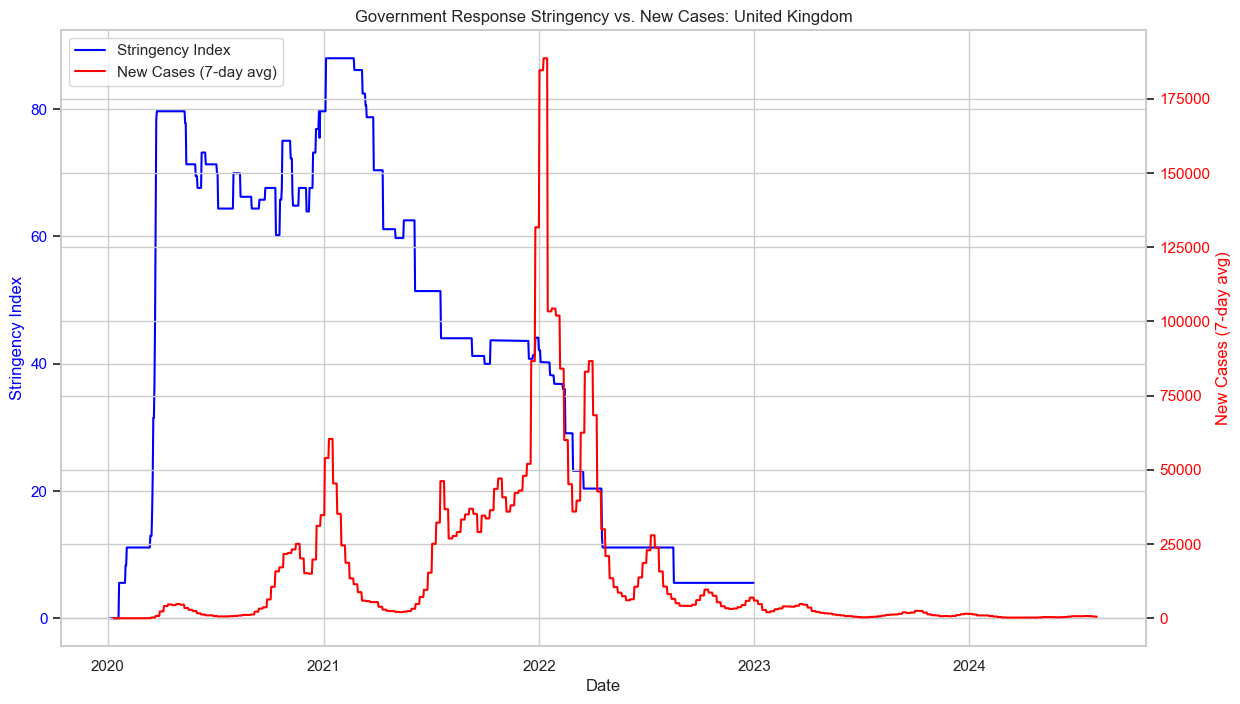

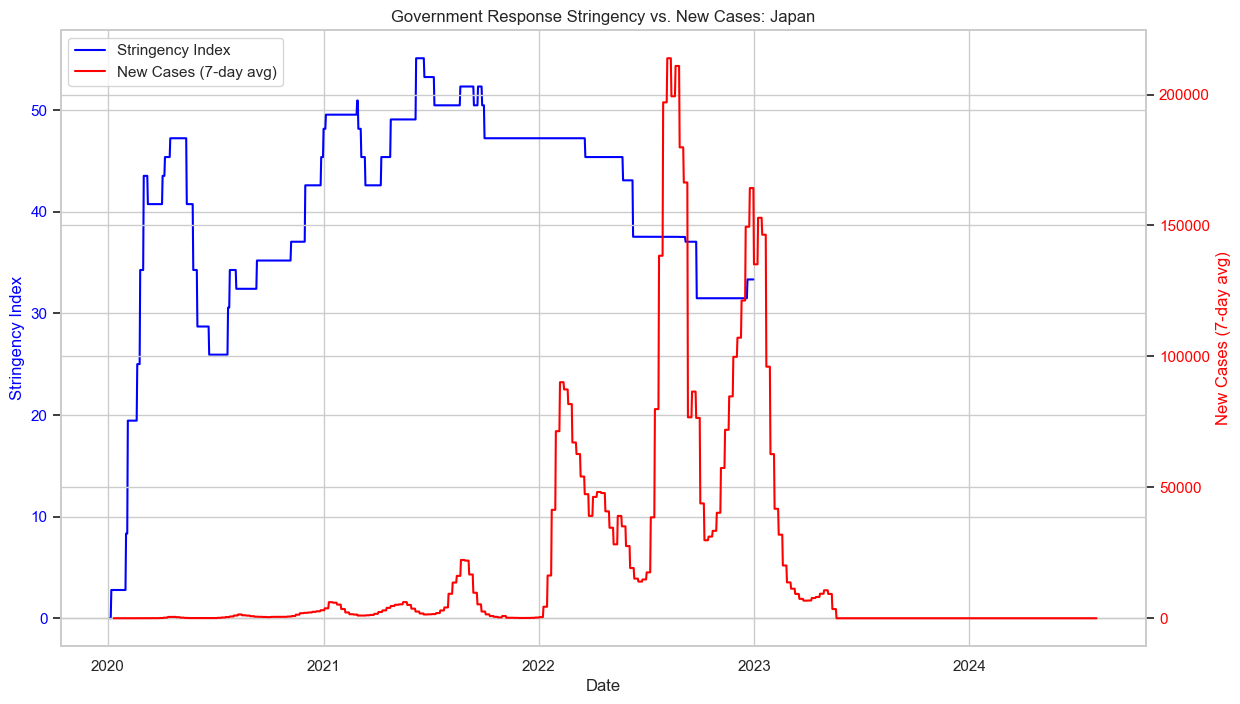

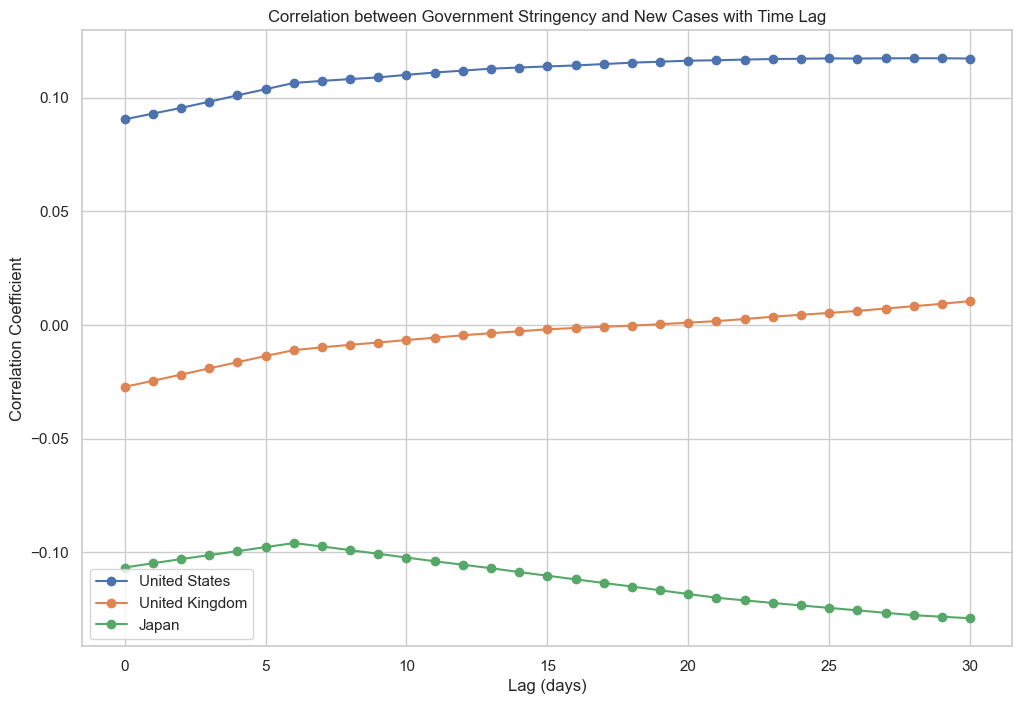

In [13]:
# Check if stringency index is available in the dataset
if 'stringency_index' in filtered_data.columns:
    # Plot stringency index vs. new cases for selected countries
    for country in ['United States', 'United Kingdom', 'Japan']:
        country_data = filtered_data[filtered_data['location'] == country].copy()
        country_data['new_cases_smoothed'] = country_data['new_cases'].rolling(window=7).mean()
        
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot stringency index
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Stringency Index', color='blue')
        ax1.plot(country_data['date'], country_data['stringency_index'], color='blue', label='Stringency Index')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create second y-axis for new cases
        ax2 = ax1.twinx()
        ax2.set_ylabel('New Cases (7-day avg)', color='red')
        ax2.plot(country_data['date'], country_data['new_cases_smoothed'], color='red', label='New Cases (7-day avg)')
        ax2.tick_params(axis='y', labelcolor='red')
        
        plt.title(f'Government Response Stringency vs. New Cases: {country}')
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        plt.grid(True)
        plt.show()
    
    # Calculate lagged correlations
    plt.figure(figsize=(12, 8))
    for country in ['United States', 'United Kingdom', 'Japan']:
        country_data = filtered_data[filtered_data['location'] == country].copy()
        country_data['new_cases_smoothed'] = country_data['new_cases'].rolling(window=7).mean()
        
        correlations = []
        for lag in range(31):  # 0 to 30 days lag
            country_data[f'stringency_lag_{lag}'] = country_data['stringency_index'].shift(lag)
            corr = country_data['new_cases_smoothed'].corr(country_data[f'stringency_lag_{lag}'])
            correlations.append((lag, corr))
        
        lags, corrs = zip(*correlations)
        plt.plot(lags, corrs, marker='o', label=country)
    
    plt.title('Correlation between Government Stringency and New Cases with Time Lag')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Stringency index not available in the dataset.")

## 8. Geospatial Analysis

Let's create choropleth maps to visualize the global distribution of COVID-19 cases and vaccinations.

In [14]:
# Install plotly if not already installed
!pip install plotly

In [17]:
import plotly.express as px

# Get the latest data for all countries
global_latest = covid_data.sort_values('date').groupby('location').last().reset_index()

# Calculate mortality rate
global_latest['mortality_rate'] = global_latest['total_deaths'] / global_latest['total_cases'] * 100

# Create choropleth map of total cases per million
fig = px.choropleth(global_latest, 
                    locations="iso_code",
                    color="total_cases_per_million", 
                    hover_name="location",
                    title="COVID-19 Total Cases per Million by Country")
fig.update_layout(height=600, width=900)
fig.show()

In [16]:
# Create choropleth map of vaccination rates
fig = px.choropleth(global_latest, 
                    locations="iso_code",
                    color="people_vaccinated_per_hundred", 
                    hover_name="location",
                    title="COVID-19 Vaccination Rates (People Vaccinated per 100) by Country")
fig.update_layout(height=600, width=900)
fig.show()

## 9. Key Insights and Conclusions

### Population Density and Infection Rates

- Our analysis reveals a complex relationship between population density and COVID-19 infection rates.
- The correlation coefficient between population density and cases per million is informative but doesn't tell the complete story.
- Some densely populated countries with strong public health measures controlled outbreaks more effectively than less dense countries with weaker responses.
- Other factors like healthcare infrastructure, testing capacity, and government policies significantly influenced infection rates.

### Vaccination Impact Analysis

- Countries with higher vaccination rates generally showed declining mortality rates.
- The correlation between vaccination rates and mortality rates demonstrates vaccine effectiveness in reducing severe outcomes.
- The relationship isn't perfectly linear, suggesting other factors like healthcare capacity, population age structure, and comorbidities also influence mortality.
- The timing of vaccination campaigns relative to outbreak waves was critical in determining their immediate impact.

### Government Response Analysis

- Government stringency measures often lagged behind case increases, suggesting reactive rather than proactive policies.
- The effectiveness of stringency measures varied across countries.
- The time lag between implementing stringency measures and observing case reductions typically ranged from 1-3 weeks.
- Countries with consistent policies generally showed better outcomes than those with frequently changing approaches.

### Limitations and Future Work

- Data quality and reporting consistency varied significantly across countries.
- Testing capacity differences make direct case comparisons challenging.
- Our analysis focused on selected countries and may not capture all global patterns.
- Future work could incorporate more detailed data on specific interventions, healthcare capacity, and demographic factors.
- Longer-term analysis of vaccination effectiveness against new variants would provide additional insights.